# Проверка гипотез, анализ А/В теста

В нашем распоряжении данные крупного интернет-магазина. Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.
Наша задача: приоритизация гипотез, проведение A/B-теста и анализ результатов.

Описание данных:

Файл /datasets/hypothesis.csv
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Файл /datasets/orders.csv
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ


Файл /datasets/visitors.csv
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

В первой части мы проведем приоритизацию гипотез (применим фреймворк ICE и RICE).

Во второй части проведем анализ A/B-теста.
Был проведен A/B-тест и получены результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.
Мы построим графики по выручкам и средним чекам, посчитаем стат. значимость, по итогам анализа примем решение о тесте.

## Подготовка данных к анализу

Первым делом подготовим данные к работе

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
import numpy as np 
import datetime as dt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 150

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
display(hypothesis)
display(hypothesis.info())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

In [3]:
display(hypothesis.isna().sum())
print('Количество явных дубликатов:', hypothesis.duplicated().sum())

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Количество явных дубликатов: 0


In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

In [5]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', parse_dates=['date'])
orders.columns = orders.columns.str.lower()
display(orders.head(10))
display(orders.info())

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

In [6]:
display(orders.isna().sum())
print('Количество явных дубликатов:', orders.duplicated().sum())

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

Количество явных дубликатов: 0


In [7]:
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', parse_dates=['date'])
display(visitors.head(10))
display(visitors.info())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

In [8]:
display(visitors.isna().sum())
print('Количество явных дубликатов:', visitors.duplicated().sum())

date        0
group       0
visitors    0
dtype: int64

Количество явных дубликатов: 0


**ВЫВОД:** в данном разделе мы привели к нижнему регистру названия столбцов и привели к формату 'datetime' столбцы содержащие даты.

## Приоритизация гипотез

Сперва применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [9]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis.sort_values(by = 'ICE', ascending = False))

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Явно выделяются следующие гипотезы:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассыло

Теперь то же самое проделаем с RICE

In [10]:
hypothesis['RICE'] = hypothesis['reach']  * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis.sort_values(by = 'RICE', ascending = False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Тут впереди всех гипотеза - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". 

У гипотезы "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" RICE в 2 раза .

А у гипотез "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"  RICE в 3 раза меньше первой гипотезы.

Так же посмотрим на график распределния гипотез в зависимости от ICE и RICE.

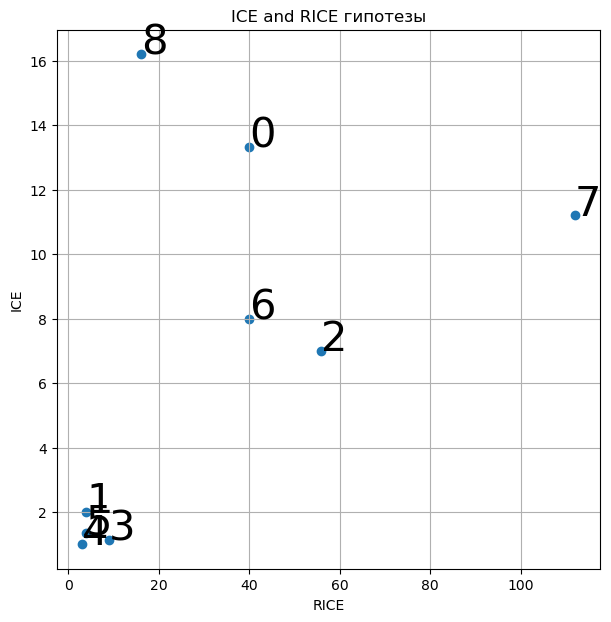

In [11]:
y = hypothesis['ICE'] 
z = hypothesis['RICE'] 
n = hypothesis.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=30)

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")
plt.grid()    

fig.set_figheight(7)
fig.set_figwidth(7) 
plt.show()  

**ВЫВОД:** гипотеза о запуске акции на день рождения, сильно просела из-за минимального охвата, в тоже время гипотеза о добавлении формы подписки на основную страницу поднялась выше из-за высокого охвата. 

## Анализ A/B-теста

Для начала проведем дополнительное исследование, и выявим:
 - сколько у нас групп в АВ-тесте в датафреймах;
 - даты начала и окончания теста в датафреймах;
 - сколько пользователей в каждой группе - по таблице с заказами;
 - кол-во посещений для каждой группы;
 - для численных данных можно посмотреть на статистические показатели.

In [12]:
print(orders['group'].unique())
print(visitors['group'].unique())

['B' 'A']
['A' 'B']


In [13]:
print(f'Дата начала теста в orders: ', orders['date'].min())
print(f'Дата окончания теста в orders: ', orders['date'].max())
print(f'Дата начала теста в visitors: ', visitors['date'].min())
print(f'Дата окончания теста в visitors: ', visitors['date'].max())

Дата начала теста в orders:  2019-08-01 00:00:00
Дата окончания теста в orders:  2019-08-31 00:00:00
Дата начала теста в visitors:  2019-08-01 00:00:00
Дата окончания теста в visitors:  2019-08-31 00:00:00


In [14]:
print('Уникальные id пользователей в группе А: ', len(orders.query('group == "A"')['visitorid'].unique()))
print('Уникальные id пользователей в группе B: ', len(orders.query('group == "B"')['visitorid'].unique()))
print('Количество заказов в группе А: ', orders.query('group == "A"')['visitorid'].count())
print('Количество заказов в группе B: ', orders.query('group == "B"')['visitorid'].count())

Уникальные id пользователей в группе А:  503
Уникальные id пользователей в группе B:  586
Количество заказов в группе А:  557
Количество заказов в группе B:  640


In [15]:
print('Средний чек в группе А: ', round(orders.query('group == "A"')['revenue'].mean()))
print('Средний чек в группе В: ', round(orders.query('group == "B"')['revenue'].mean()))

Средний чек в группе А:  7334
Средний чек в группе В:  9231


Проверим, нет ли пользователей с уникальными id, которые попали в обе группы.

In [16]:
ordersA = orders.query('group == "A"')
ordersB = orders.query('group == "B"')
both_groups = set(ordersA['visitorid']).intersection(set(ordersB['visitorid']))
len(both_groups)

58

58 пользователей состоят в обоих группах. Удалять мы их не будем, так как на конечном результате, это не даст нам ощутимой разницы.

### Построение графика кумулятивной выручки по группам

Для постороения графика, нам потребуется таблица с разделением по группам и датам.

In [17]:
datesGroups = orders[['date','group']].drop_duplicates() 

datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionid' : pd.Series.nunique,
'visitorid' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max', 
'group' : 'max', 
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max', 
'group' : 'max', 
'transactionid' : 'nunique', 
'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max', 
'group' : 'max', 
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(10))
print(cumulativeData['date'].min())
print(cumulativeData['date'].max())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845
5 2019-08-03     B      61      59   380996      1803
6 2019-08-04     A      84      77   425699      2562
7 2019-08-04     B      78      75   489567      2573
8 2019-08-05     A     109     100   549917      3318
9 2019-08-05     B     101      98   581995      3280
2019-08-01 00:00:00
2019-08-31 00:00:00


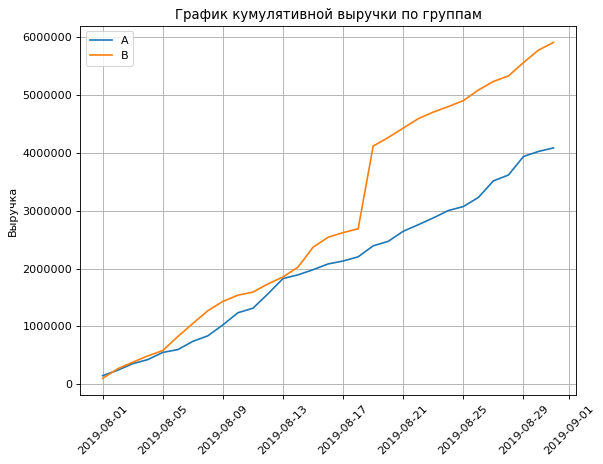

In [18]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

figure(figsize=(8, 6), dpi=80)
plt.ticklabel_format(style='plain')

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Выручка в группе А растет постепенно, а в группе В после 17 августа, наблюдается резкий скачок. 

### График кумулятивного среднего чека по группам

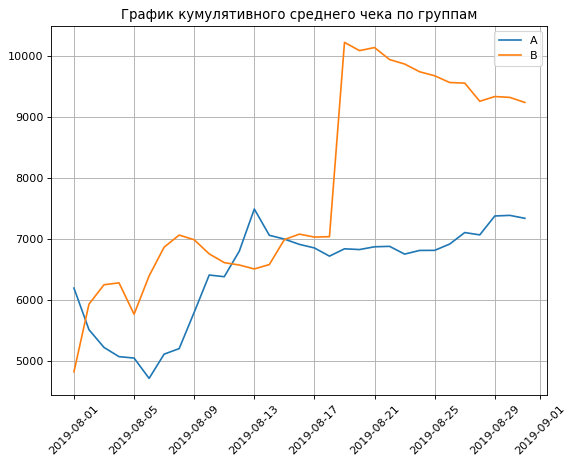

In [19]:
figure(figsize=(8, 6), dpi=80)
plt.ticklabel_format(style='plain')

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

К 17.08 средний чек начинает выравниваться, и в это время в группе В происходит какая-то крупная покупка, и средний чек группы В резко вырастает. Дальнейшее наблюдение скорее всего сравняло бы группы.

### График относительного изменения кумулятивного среднего чека группы B к группе A

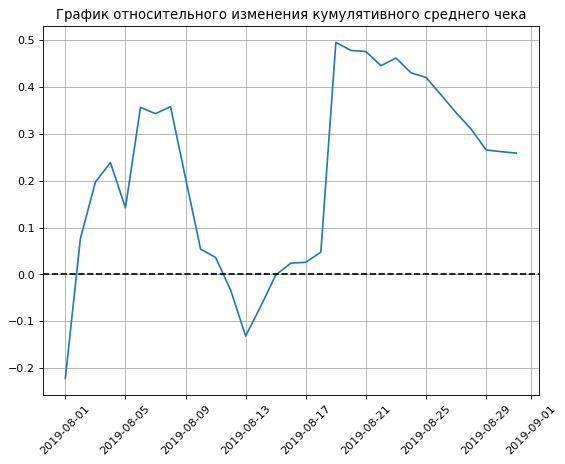

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

figure(figsize=(8, 6), dpi=80)
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Данный график еще раз показывает нам наличие аномальных заказов, только теперь, помимо 17.08, появились еще выбросы.

### График кумулятивного среднего количества заказов по группам

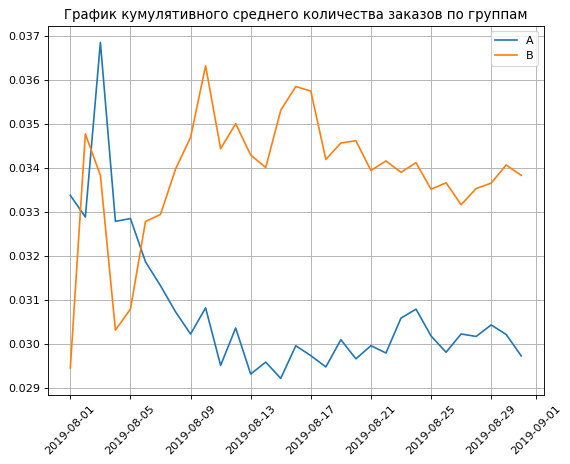

In [21]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

figure(figsize=(8, 6), dpi=80)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов по группам')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

В начале теста были скачки конверсии, но со временем они приняли свое значение, и группа В выглядит более предпочтительно.

###  График относительного изменения кумулятивного среднего количества заказов группы B к группе A

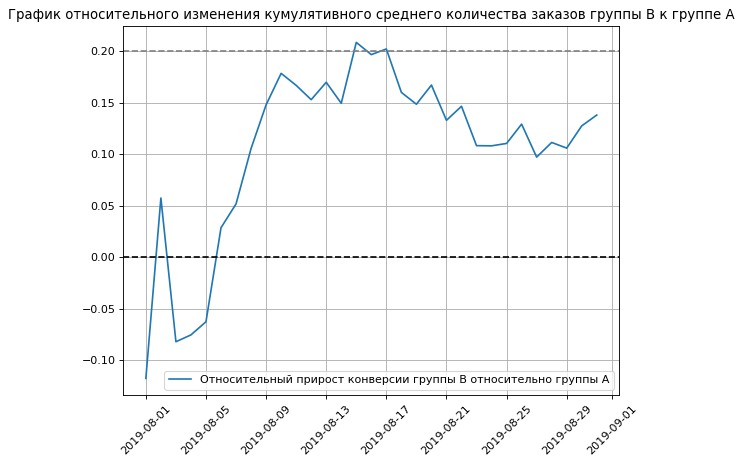

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

figure(figsize=(8, 6), dpi=80)
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов группы B к группе A')
plt.xticks(rotation=45)
plt.grid(True)

В начале группа В сильно и резко обогнала группу А, но со временем отношение количества заказов пошло на спад.

### График количества заказов по пользователям

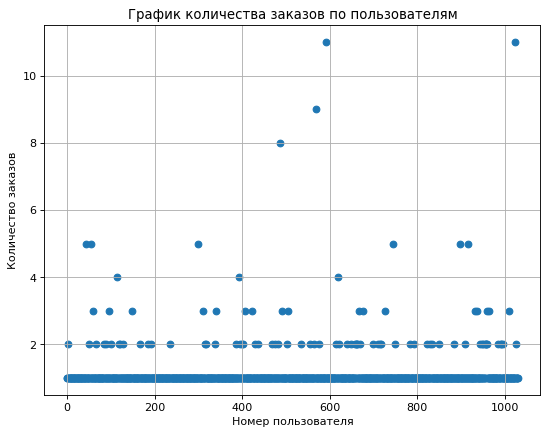

In [23]:
ordersByUsers = orders.groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'})
ordersByUsers.columns = ['userId', 'orders']
x_values = pd.Series(range(0,len(ordersByUsers)))
figure(figsize=(8, 6), dpi=80)
plt.title('График количества заказов по пользователям')
plt.ylabel("Количество заказов")
plt.xlabel("Номер пользователя")
plt.scatter(x_values, ordersByUsers['orders'])
plt.grid(True)
None

Из данного графика видно, что основная масса покупателей совершает один заказ. Так же видны два пользователя с 11 заказами.

### Выбор границы для определения аномальных пользователей

In [24]:
print(ordersByUsers.sort_values(by='orders', ascending=False).head(15))
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5
393   1614305549       4
114    457167155       4
619   2587333274       4
340   1404934699       3
937   3908431265       3
[2. 4.]


Не более 5% пользователей совершили больше 2 заказов и не более 1% совершили более 4 заказов. 

На основе полученных данных, принимаем решение отсечь всех пользователей с количеством заказов больше 2.

### График стоимости заказов

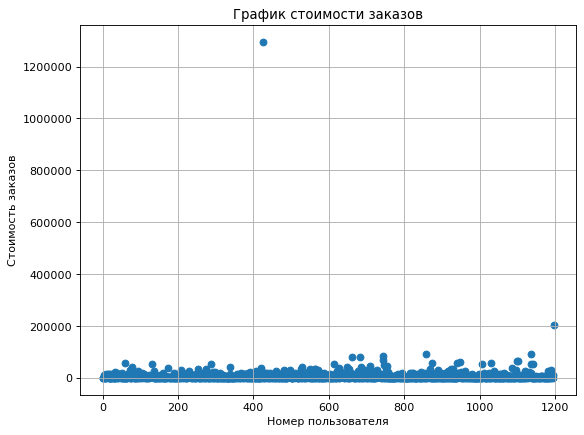

In [25]:
x_values = pd.Series(range(0, len(orders['revenue'])))
figure(figsize=(8, 6), dpi=80)
plt.scatter(x_values, orders['revenue']) 
plt.title('График стоимости заказов')
plt.ylabel("Стоимость заказов")
plt.xlabel("Номер пользователя")
plt.ticklabel_format(style='plain')
plt.grid(True)
None

Явно выделяются 2 выброса, в следующей теме мы избавимся от них.

### 95-й и 99-й перцентили стоимости заказов

In [26]:
print(orders.sort_values(by='revenue', ascending=False).head(15))
print(np.percentile(orders['revenue'], [95, 99])) 

      transactionid   visitorid       date  revenue group
425       590470918  1920142716 2019-08-19  1294500     B
1196     3936777065  2108080724 2019-08-15   202740     B
858       192721366  1316129916 2019-08-27    93940     A
1136      666610489  1307669133 2019-08-13    92550     A
744      3668308183   888512513 2019-08-27    86620     B
682      1216533772  4266935830 2019-08-29    78990     B
662      1811671147  4266935830 2019-08-29    78990     A
743      3603576309  4133034833 2019-08-09    67990     A
1103     1348774318  1164614297 2019-08-12    66350     A
1099      316924019   148427295 2019-08-12    65710     A
949      1347999392   887908475 2019-08-21    60450     A
940      2420050534  4003628586 2019-08-08    58550     B
1029      469609643  2378935119 2019-08-10    58220     A
873      2519737434  4256040402 2019-08-08    58220     B
60       1421016313  4256040402 2019-08-16    56650     B
[28000.  58233.2]


Здесь так же отсечем все что выше 95 перцентиля (заказы свыше 28000).

### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным.

Сформулируем нулевую гипотезу: статистически значимых различий в среднем числе заказов между группами **нет**.

Алтернативная гипотеза соответсвенно - в среднем числе заказов между группами **есть** статистически значимые различия.

In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1,).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA',]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1,).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB',]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
 
ordersByUsersA = (orders[orders['group'] == 'A'].groupby('visitorid', as_index=False).agg({
    'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
 
    
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(
    data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(
    0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(
    0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0,index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0,)

sampleB = pd.concat(
    [ordersByUsersB['orders'],pd.Series(0, index=np.arange(
        data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0,)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01679
0.138


Р-value = 0.017, что меньше 0.05. Значит, нулевую гипотезу отвергаем. Принимаем альтернативную: в среднем числе заказов между группами **есть** статистически значимые различия. Относительный прирост среднего группы B к конверсии группы А равен 13.8%.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. 

Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [28]:
print('{0:.3f}'.format(
    stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value значительно больше 0.05. Нулевая гипотеза, о том, что в среднем чеке **НЕТ** различий  подтвердилась. В то же время, средний чек группы B выше среднего чека группы A.

### Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным

Нулевая гипотеза: статистически значимых различий в среднем числе заказов между группами **нет**.

Алтернативная гипотеза соответсвенно - в среднем числе заказов между группами **есть** статистически значимые различия.

Первым делом определим аномальных пользователей.

In [29]:
usersWithManyOrders = pd.concat([
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[0]]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[0]]['userId']],axis=0,)

usersWithExpensiveOrders = orders[orders['revenue'] >= np.percentile(orders['revenue'], [95, 99])[0]]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()
print(abnormalUsers.head())

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64


In [30]:
sampleAFiltered = pd.concat([ordersByUsersA[
    np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], pd.Series(0,index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0,index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.013
0.173


Как и в случае с сырыми данными, нулевая гипотеза не подтвердилась. В среднем числе заказов есть статистически значимые различия. Относительный прирост немного вырос, и стал 17.3%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. 

Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [31]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],orders[np.logical_and(
                    orders['group'] == 'B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorid']
            .isin(abnormalUsers)),)]['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),)]['revenue'].mean() - 1))

0.738
-0.020


P-value почти не изменился, а разница между средними чеками изменилась с 25.9% до 2%.

Не получилось отвергнуть нулевую гипотезу.

## Вывод:

Полученных данных достаточно, чтобы выявить "победу" группы В, при чем как по "сырым", так и по "отфильтрованным" данным. 

На графиках мы так же видим, что конверсия группы В зафиксировалась примерно на одном уровне, который выше группы А.

В среднем чеке обоих групп, разница не большая.